# Session을 이용해 로그인하기

## 쿠키(Cookie), 세션(Session)

- 웹은 대다수가 HTTP 기반으로 동작한다. 하지만, HTTP가 구현된 방식에서 웹 서버와 클라이언트는 지속적으로 연결을 유지한 상태가 아니라, `요청(request) - 응답(response)`의 반복일 뿐이기 때문에, 이전 요청과 새로운 요청이 같은 사용자(같은 브라우저)에서 이루어졌는지를 확인하는 방법이 필요하다.
    - 이 때, 등장하는 것이 `쿠키`와 `세션`이다.

- 쿠키는 `유저가 웹사이트를 방문할 때 사용자의 브라우저에 심겨지는 작은 파일`인데, `Key - Value` 형식으로 로컬 브라우저에 저장된다. 서버는 이 쿠키의 정보를 읽어 HTTP 요청에 대해 브라우저를 식별한다.


- 그러나 쿠키는 로컬에 저장된다는 근원적인 문제로 인해 악의적 사용자가 쿠키를 변조하거나 탈취해 정상적이지 않은 쿠키로 서버에 요청을 보낼 수 있다. 만약 '로그인됨'이라는 식별을, 로컬 쿠키만을 신뢰해 로그인을 한 상태로 서버가 인식한다면 쿠키 변조를 통해 마치 관리자나 다른 유저처럼 행동할 수 있다.

- 이로 인해 서버 측에서 클라이언트를 식별하는 '세션'을 주로 이용하게 된다.

- 세션은 `브라우저가 웹 서버에 요청을 한 경우 서버 내에 해당 세션 정보를 파일이나 DB에 저장하고 클라이언트의 브라우저에 session-id라는 임의의 긴 문자열을 준다. 이 때 사용되는 쿠키는 클라이언트와 서버 간에 연결이 끊어진 경우 삭제되는 메모리 쿠키를 이용한다.`

## requests의 Session

- requests에는 Session이라는 모듈이 있다.

In [2]:
import requests

## Session 생성
s = requests.Session()

- Session은 위와 같은 방식으로 만들 수 있다.
- 이렇게 만들어진 세션은 이전 게시글에서의 `requests`위치를 대신하는데, 이전 게시글의 코드를 바꿔본다면 아래와 같다.

In [4]:
import requests

# Session 생성
s = requests.Session()

# HTTP GET Request : requests 대신 s 객체를 이용한다.
req = s.get('https://www.clien.net/service')

# HTML 소스 가져오기
html = req.text
# HTML Header 가져오기
header = req.headers
# HTTP Status 가져오기 (200 : 정상)
status = req.status_code
# HTTP가 정상적으로 되었는지 (True / False)
is_ok = req.ok

- with 구문
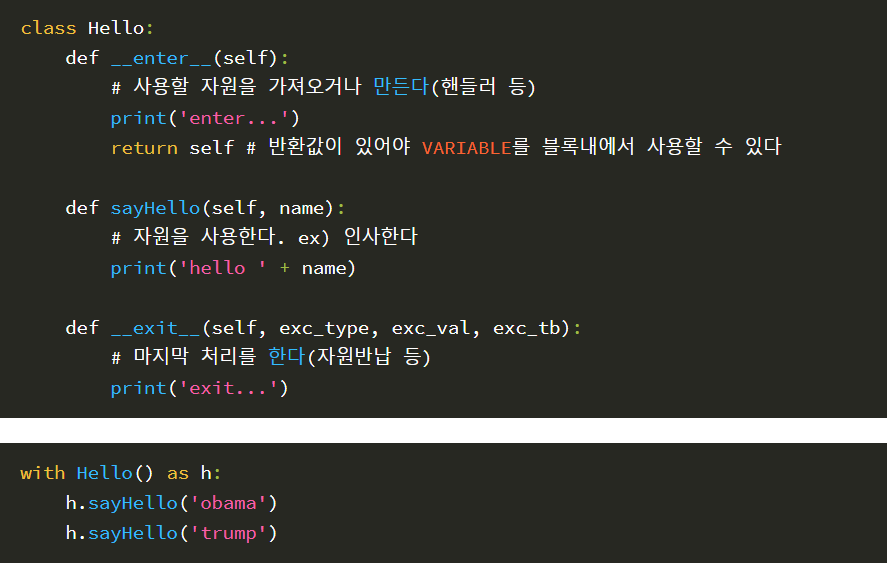
- 출처 : https://m.blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221653260516&proxyReferer=https:%2F%2Fwww.google.com%2F

In [9]:
import requests

# Session, with 구문 안에서 유지
with requests.Session() as s:
    req = s.get('https://www.clien.net/service')
    html = req.text
    header = req.headers
    status = req.status_code
    is_ok = req.ok

## 로그인하기
- 로그인을 구현하기 위한 예시로 클리앙에 로그인해 클리앙 장터를 크롤링해보자.

- 로그인 창에 검사를 통해 로그인 폼 필드의 name값을 알아보자.
- 아래 스크린샷을 보면 `input`필드들의 `name`이
    - `_csrf`
    - `userID`
    - `userPassword`
    - `remember-me`
    가 있는 것을 확인할 수 있다.
- 또한, 로그인 버튼을 누르면 `auto.login()`이라는 자바스크립트 함수가 먼저 실행되는 것을 확인할 수 있다.

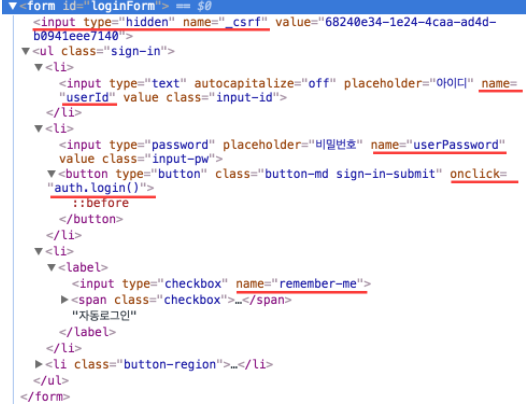

- 로그인을 구현하기 전, HTML form에 대해서 간단하게 알아보자.

HTML form Field에서는 `name : 입력값`이라는 Key:Value 식으로 데이터를 전달한다( 주로 POST 방식)
    - POST 방식
    POST 방식은 GET 방식과 달리, 데이터 전송을 기반으로 한 요청 메서드이다.
    GET방식은 `URL에 데이터를 붙여서 보내`는 반면, `POST방식은 URL에 붙여서 보내지 않고
    BODY에다가 데이터를 넣어서 보낸다`.  
클리앙 로그인 폼 필드의 경우 `userID : 사용자id`, `userPassword : 사용자pw`라는 세트로 입력을 받는 것을 볼 수 있다.

그리고 약간 특이해보이는 `_csrf`라는 것도 있는데, 원래 CSRF는 사용자의 요청이 악의적이거나 제 3자에 의해 변조된(해킹된) 요청이 아닌지 확인해주는 보안 도구 중 하나이다.
세션과 연결되어 form을 전달할 때 form의 안정성을 높여준다.

새로고침하면 매번 달라지는 CSRF 값을 확인할 수 있다. 그리고, CSRF를 사용하는 경우 CSRF값이 없는 form 전송은 위험한 요청으로 생각하고 form을 받아들이지 않는다.(즉, 로그인이 되지 않는다.) 따라서 우리는 `_csrf`라는 것도 함께 전송해줘야 한다. 따라서 메인 화면을 먼저 가져와 `_csrf`필드를 가져오고 로그인을 해야 한다.

다음으로는 `auth.login()`이라는 함수를 살펴보면, 그냥 입력 유무만 확인하는 심플한 함수이다. 사실 이것보다 더 길지만, 실제로 `login` 함수에서 사용되는 코드 부분은 이 부분이 전부이기 때문에 뒷부분은 잘랐다.


function Auth() {
    var _this = this; // _this에 Auth라는 함수를 넣었습니다.
    _this.env = {};
    _this.env.form = $('#loginForm'); // 로그인 폼입니다. id, pw, _csrf 등을 받는다고 위에서 확인했죠?
    _this.env.iptUserId = _this.env.form.find('*[name=userId]'); // 사용자가 폼에 입력한 ID입니다.
    _this.env.iptUserPassWord = _this.env.form.find('*[name=userPassword]'); // 사용자가 폼에 입력한 PW입니다.

    _this.loginValidate = function() {
        var isValid = true; // 아무 문제가 없다면(id나 pw가 빈칸이 아니라면) true를 반환하는 함수입니다.
        if (_this.env.iptUserId.val().trim() == '') { // 아이디가 빈칸이면 false죠?
            alert('아이디를 입력하세요.');
            _this.env.iptUserId.focus();
            isValid = false;
            return isValid;
        }
        if (_this.env.iptUserPassWord.val().trim() == '') { // 비번이 빈칸이어도 false가 됩니다.
            alert('비밀번호를 입력하세요.');
            _this.env.iptUserPassWord.focus();
            isValid = false;
            return isValid;
        }
        return isValid;
    };

    _this.login = function() {
        var isValid = _this.loginValidate(); // 방금 본 아이디/비번이 빈칸인지 확인하기
        if (isValid) { // 빈칸이 아니라면 ->
            _this.env.form.attr({ // 폼 속성을 정의해 줍시다.
                method: 'POST', // 폼 전송 방식은 'POST'이고,
                action: BASE_URL + '/login' // 폼 전송하는 주소는 https://www.clien.net/service/login 이네요!
            });
            _this.env.form.submit(); // 진짜로 폼을 전송해줍니다.
        }
    };
}

- 위 자바스크립트 코드에서 알게된 것은 아이디와 비밀번호 폼에 빈칸이 없다면 `POST`방식으로 `https://www.clien.net/service/login`에 폼을 전송해 로그인을 한다는 것이다.
- 한번 이 주소에 폼 값들만 넣어서 전송해보자.

In [13]:
import requests

# 로그인할 유저 정보를 넣어주자 (모두 문자열)
LOGIN_INFO = {
    'userId': '사용자이름',
    'userPassword': '사용자패스워드'
}

# Session 생성, with 구문 안에서 유지
with requests.Session() as s:
    # HTTP POST request : 로그인을 위해 POST url와 함께 전송될 data를 넣어주자.
    login_req = s.post('https://www.clien.net/service/login', data = LOGIN_INFO)
    print(login_req.status_code)

404


- `_csrf`가 없어서 그런지 제대로 로그인이 되지 않았다.
- 공식 홈페이지에서 form에 들어있는 `_csrf`값을 가져와보자.

In [18]:
import requests
from bs4 import BeautifulSoup as bs

LOGIN_INFO = {
    'userId' : 'myidid',
    'userPassword' : 'mypassword123'
}

# Session 생성, with 구문안에서 유지
with requests.Session() as s:
    # 홈페이지
    first_page = s.get('https://www.clien.net/service')
    html = first_page.text
    soup = bs(html, 'html.parser')
    # input 태그 중에서 name이 csrf인 것을 찾는다
    csrf = soup.find('input', {'name' : '_csrf'})
    print(csrf['value'])
    
    ## 이제 LOGIN_INFO에 csrf값을 넣어주자.
    # ps) python3에서 두 dict를 합치는 방법은 {**dict1, **dict2}로 모든 dict들을 unpacking하는 것
    LOGIN_INFO = {**LOGIN_INFO, **{'_csrf':csrf['value']}}
    print(LOGIN_INFO)
    
    # 다시 로그인을 해보자.
    login_req = s.post('https://www.clien.net/service')
    print(login_req.status_code)
    # 로그인이 되지 않으면 경고
    if login_req.status_code != 200:
        raise Exception('로그인이 되지 않았어요! 아이디와 비밀번호를 다시 한번 확인해주세요.')
        
    # -- 여기서부터는 로그인이 된 세션이 유지됩니다 --
    # 이제 장터의 게시글 하나를 가져와 봅시다. 아래 예제 링크는 중고장터 공지글입니다.
    post_one = s.get('https://www.clien.net/service/board/rule/10707408')
    soup = bs(post_one.text, 'html.parser') # Soup으로 만들어 줍시다.
    # 아래 CSS Selector는 공지글 제목을 콕 하고 집어줍니다.
    
    title = soup.select('#div_content > div.post-title > div.title-subject > div')
    contents = soup.select('#div_content > div.post.box > div.post-content > div.post-article.fr-view')
    # HTML을 제대로 파싱한 뒤에는 .text속성을 이용합니다.
    print(title[0].text) # 글제목의 문자만을 가져와봅시다.
    # [0]을 하는 이유는 select로 하나만 가져와도 title자체는 리스트이기 때문입니다.
    # 즉, 제목 글자는 title이라는 리스트의 0번(첫번째)에 들어가 있습니다.
    print(contents[0].text) # 글내용도 마찬가지겠지요?

02f6ee54-ada3-43a7-8bd0-15a68c9085d2
{'userId': 'myidid', 'userPassword': 'mypassword123', '_csrf': '02f6ee54-ada3-43a7-8bd0-15a68c9085d2'}
200


IndexError: list index out of range

- 성공적으로 로그인이 되었다.

## 진짜 데이터를 가져와보자.

- 로그인이 실패한 경우 Exception을 만들고, 성공일 경우에는 회원 장터의 게시글을 가져와보자.
- 